# Diminishing returns of increasing cell type diversity can explain cell type allometry

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import partial
from scipy.optimize import curve_fit 
import pymc as pm
import arviz as az

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

### Definitions

In [57]:
def fitfun_power(N,off,slope_small,slope_large,Nbp):

    return [off + slope_small*n if n < Nbp 
            else off + slope_small*Nbp + slope_large*(n-Nbp)
            for n in N]

def fitfun_dimret(N,A,B):
    return np.log10(A + B*N)

def BIC(rss,n_dat,n_params):
    return n_dat*np.log(rss/n_dat) + n_params*np.log(n_dat)

def plot_model(dat,trace,ax,hdp_prob=95):
    
    mu_mean = trace.posterior['mu'].mean(axis=1).mean(axis=0)

    # plot mean
    ax.plot(x_dat,mu_mean,'-', color=mypalette[0],lw=3,label = 'mean regression curve')

    # plot hdi for mean (=regression curve)  
    sig = az.plot_hdi(x_dat, trace.posterior['mu'], hdi_prob=hdp_prob/100, 
                      fill_kwargs = {'label' : str(hdp_prob)+"% HDI of regression curve"},
                      color=mypalette[0],ax=ax)

    # plot hdi for ppd
    sigpp = az.plot_hdi(x_dat, trace.posterior_predictive['y'], 
                        fill_kwargs = {'label' : str(hdp_prob)+"% HDI of ppd"},
                        hdi_prob=hdp_prob/100, color=mypalette[1],ax=ax)

    # plot data
    ax.plot(np.log10(dat['N']),np.log10(dat['K']),'o',markersize=10,
             markeredgecolor='black',markerfacecolor='white',markeredgewidth=2,
             label = 'data from Fisher et al.')

    # az.plot_lm(idata=trace,x=x_dat,y='y',y_model='mu',kind_pp="hdi", kind_model="hdi")

    ax.set_ylim([-0.8,2.5])
    ax.set_xlabel('$log_{10}$(Number of cells)')
    ax.set_ylabel('$log_{10}$(Number of cell types)')


def get_post_mean(trace,param):
    return np.round(trace.posterior[param].mean().values,2)

def get_hdi(trace,param):
    return np.round(az.hdi(trace,hdi_prob=0.95),2)[param].values

mypalette = ['xkcd:royal blue','xkcd:tangerine']

### Load data

In [58]:
data = pd.read_excel('./curbio10341mmc2.xlsx')
dat = data.loc[:,['Total number of cells','Number of cell types']].dropna()
dat.columns = ['N','K']

# breakpoint reported by Fisher et al.
Nbp = np.log10(6.3e4)

/anaconda3/envs/SCALE_pymc/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


# Rough analysis with ordinary least squares fit 

/anaconda3/envs/SCALE_pymc/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


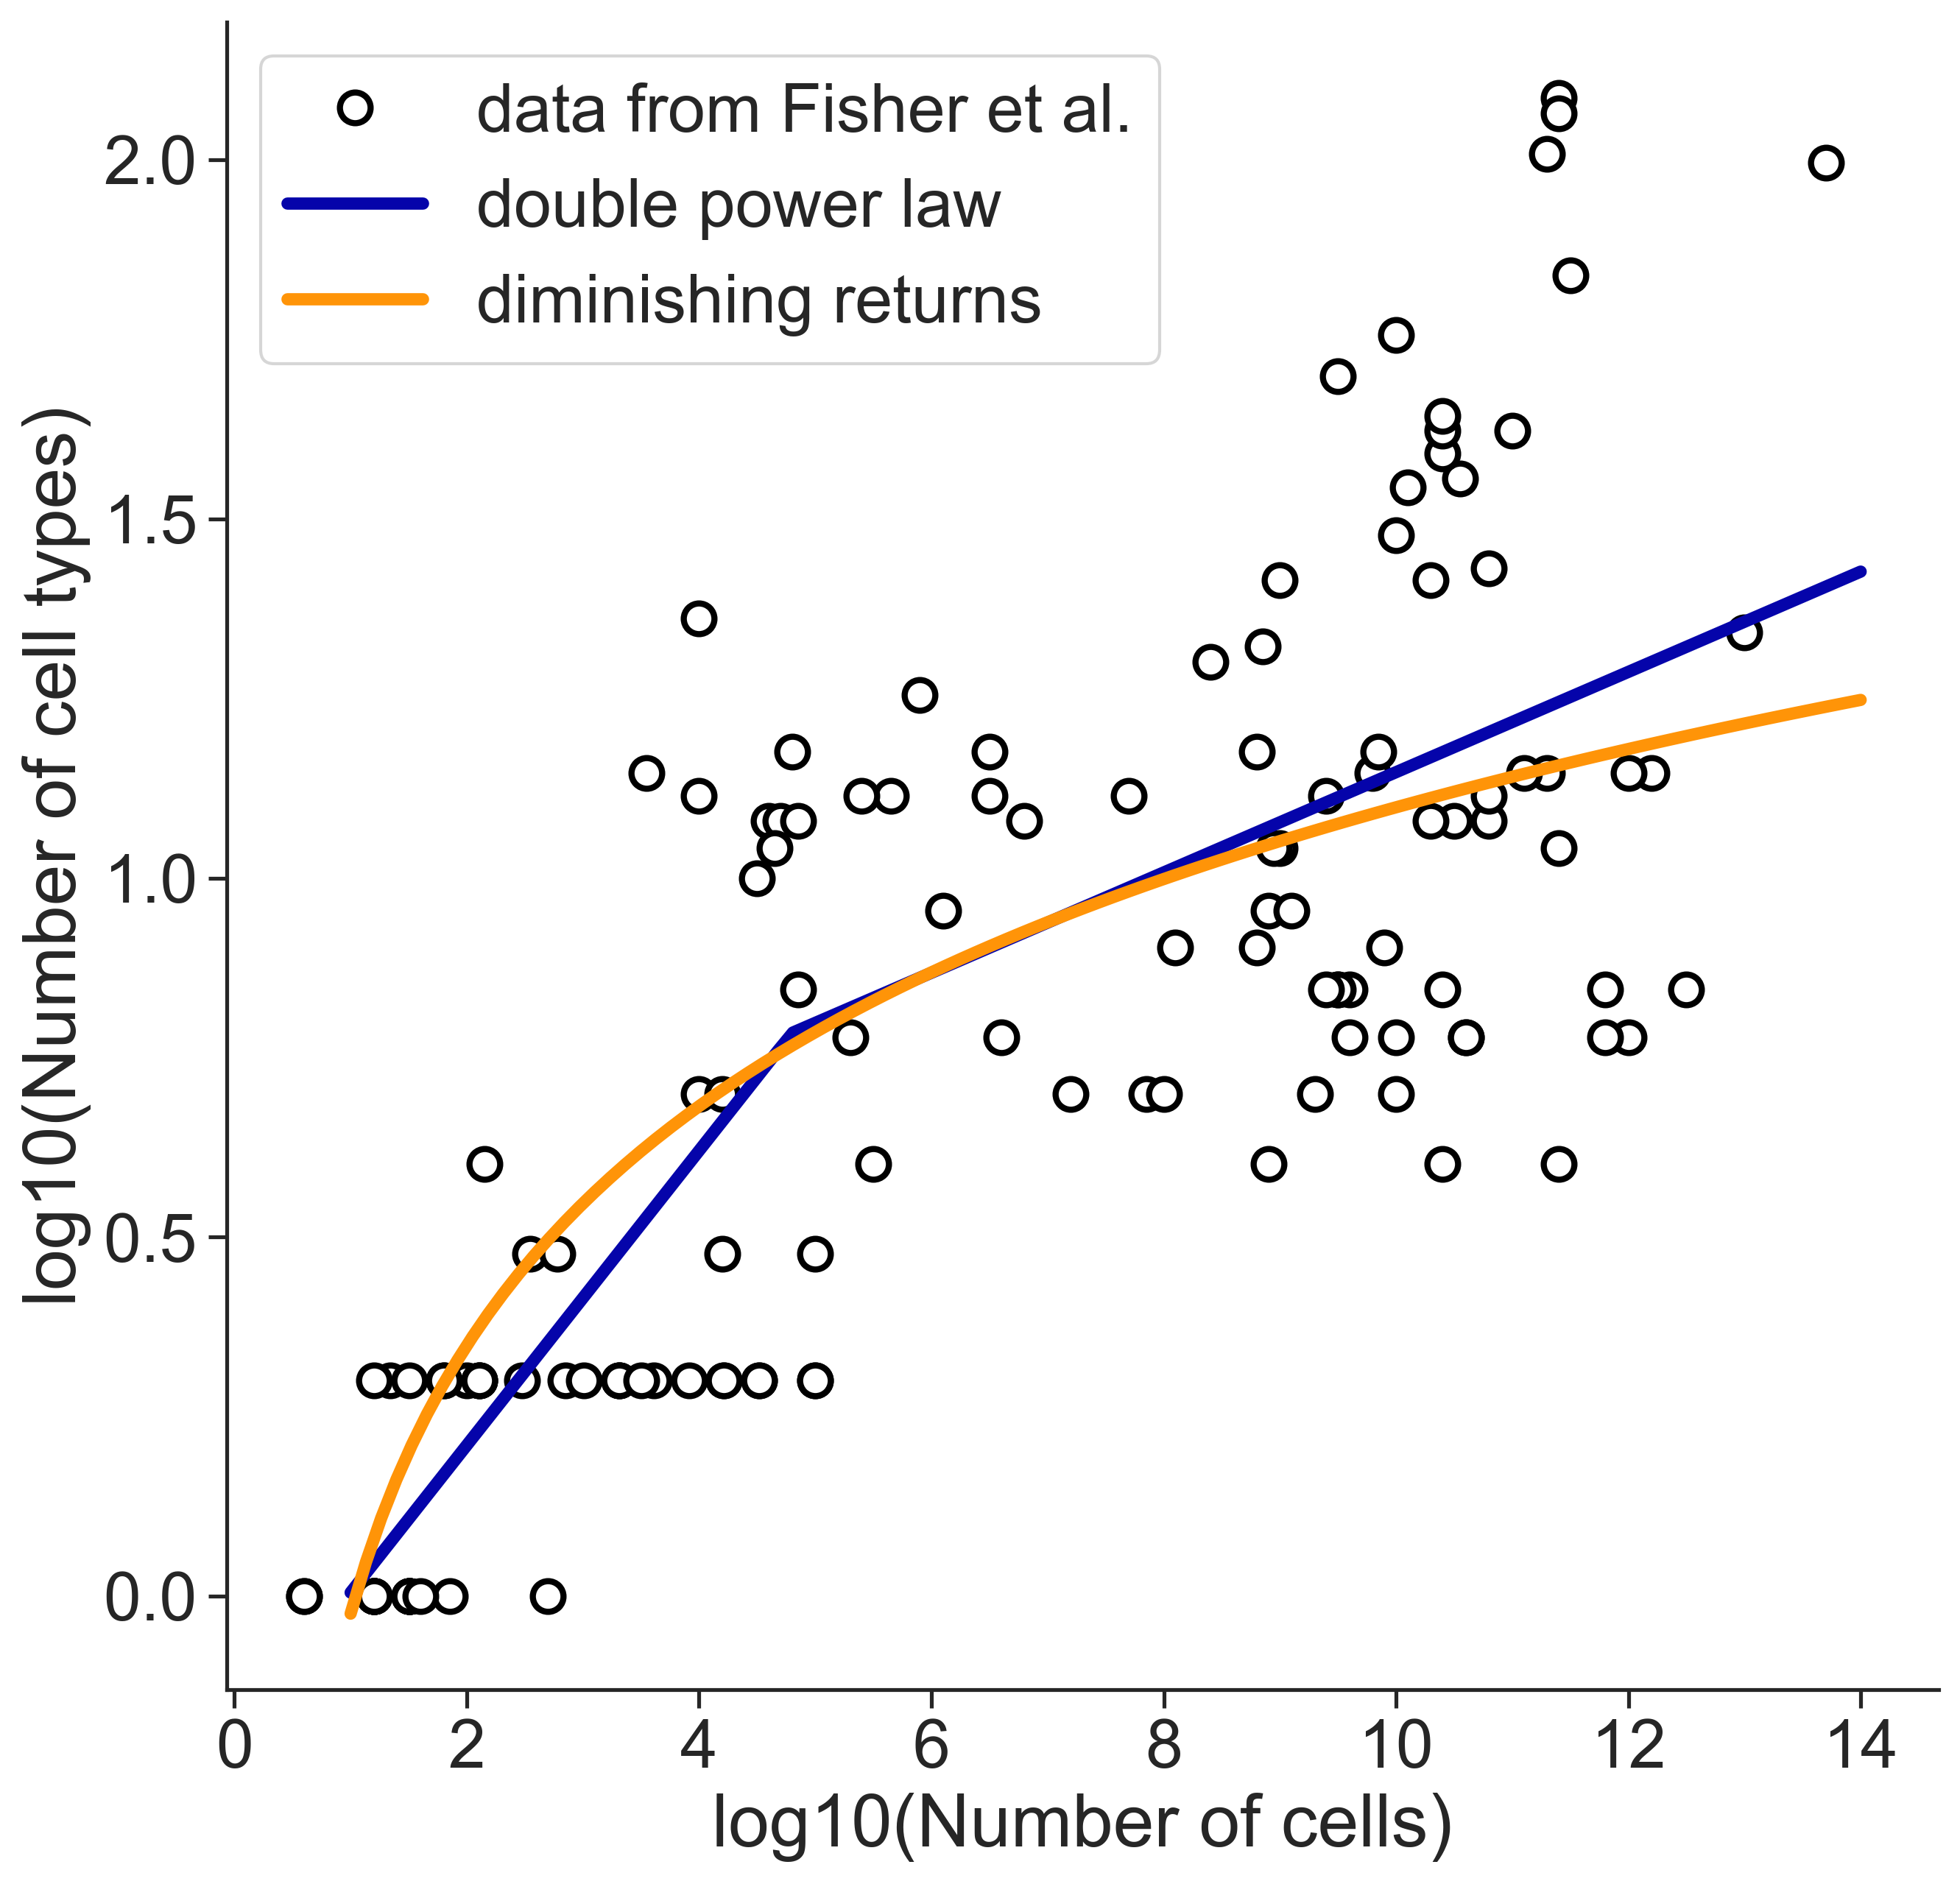

In [59]:
sns.set(font_scale=2,style="ticks")
fig,ax = plt.subplots(figsize=[10,10],dpi=300)


# plot data
plt.plot(np.log10(dat['N']),np.log10(dat['K']),'o',markersize=10,
         markeredgecolor='black',markerfacecolor='white',markeredgewidth=2)


# fit double power law 
fitfun = partial(fitfun_power,Nbp=Nbp)
fitparam_power,pcov = curve_fit(fitfun,np.log10(dat['N']),np.log10(dat['K']))

# obtain residual sum of squares for double power law
RSS_power = sum((np.log10(dat['K']) - fitfun_power(np.log10(dat['N']),*fitparam_power,Nbp=Nbp))**2)


# plot double power law
x = np.linspace(1,14,100)
y = fitfun_power(x,*fitparam_power,Nbp=Nbp)
l1 = ax.plot(x,y,'-',color=mypalette[0],linewidth=4);


# fit 'diminishing returns' model
fitparam_dimret,pcov = curve_fit(fitfun_dimret,np.log10(dat['N']),np.log10(dat['K']))

# obtain residual sum of squares for 'diminishing returns' model
RSS_new = sum((np.log10(dat['K']) - fitfun_dimret(np.log10(dat['N']),*fitparam_dimret))**2)

# # plot 'diminishing returns' model
x = np.linspace(1,14,100)
y = fitfun_dimret(x,*fitparam_dimret)
l2 = ax.plot(x,y,'-',color=mypalette[1],linewidth=4);

ax.set_xlabel('log10(Number of cells)')
ax.set_ylabel('log10(Number of cell types)')

ax.legend(['data from Fisher et al.','double power law','diminishing returns'])

sns.despine()


Residual sum of squares [RSS new model, RSS double power law]

In [60]:
np.round([RSS_new,RSS_power],2)

array([14.28, 13.22])

Bayesian information criterion [BIC new model, BIC double power law] 

In [61]:
np.round([BIC(RSS_new,dat.shape[0],2),BIC(RSS_power,dat.shape[0],3)],2)

array([-286.99, -292.41])

Double power law parameters [offset, slope_small, slope_large]

In [62]:
fitparam_power

array([-0.1998514 ,  0.20506008,  0.06980782])

New model parameters : [A,B]

In [63]:
fitparam_dimret

array([-0.34285462,  1.28871636])

# Bayesian hierarchical models

In [64]:
x_dat = np.log10(dat.sort_values(by='N')['N'])
y_dat = np.log10(dat.sort_values(by='N')['K'])

# number of tuning and sampling steps for Monte Carlo sampling
Ntune = 2000
Nsample = 10000

## Model definition and sampling

In [65]:
models = ['double power law, constant sd','double power law, variable sd',
         'diminishing returns, constant sd', 'diminishing returns, variable sd']

trace = dict()

### Double power law, constant sd 

double power law, constant sd


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slope_small, breakpoint, slope_large, sigma]


Sampling 2 chains for 2_000 tune and 10_000 draw iterations (4_000 + 20_000 draws total) took 111 seconds.
The acceptance probability does not match the target. It is 0.9012, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


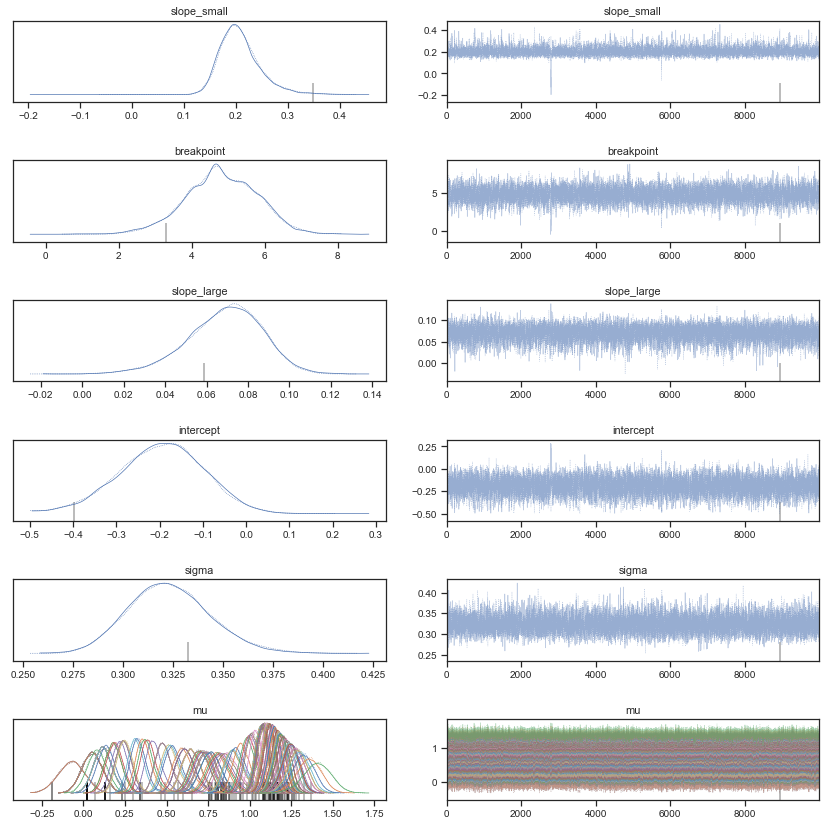

In [66]:
model = models[0]
print(model)

with pm.Model() as pm_model:

    # model definition
    intercept = pm.Uniform('intercept', lower=-0.5, upper=0.5, initval = 0.1)
    slope_small = pm.Normal('slope_small', mu=0, sigma=20)
    breakpoint = pm.Normal('breakpoint', mu=5, sigma=2, initval=5)
    slope_large = pm.Normal('slope_large', mu=0, sigma=20)

    part_1 = intercept + slope_small * x_dat
    part_2 = intercept + slope_small * breakpoint - slope_large * (breakpoint - x_dat)
    
    mu = pm.Deterministic('mu',pm.math.switch(breakpoint > x_dat,part_1,part_2))

    sigma = pm.HalfCauchy('sigma', beta=10, initval=1)
    
    likelihood = pm.Normal('y', mu=mu,sigma=sigma,observed=y_dat)

    # sampling
    trace[model] = pm.sample(Nsample,target_accept=0.8,tune=Ntune, progressbar=True,random_seed=rng)    
    pm.sample_posterior_predictive(trace[model], extend_inferencedata=True,random_seed=rng)
    
# check trace
az.plot_trace(trace[model])
plt.tight_layout()


### Double power law; sd depends on cell number

double power law, variable sd


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slope_small, breakpoint, slope_large, sigma_intercept, sigma_slope]


Sampling 2 chains for 2_000 tune and 10_000 draw iterations (4_000 + 20_000 draws total) took 95 seconds.


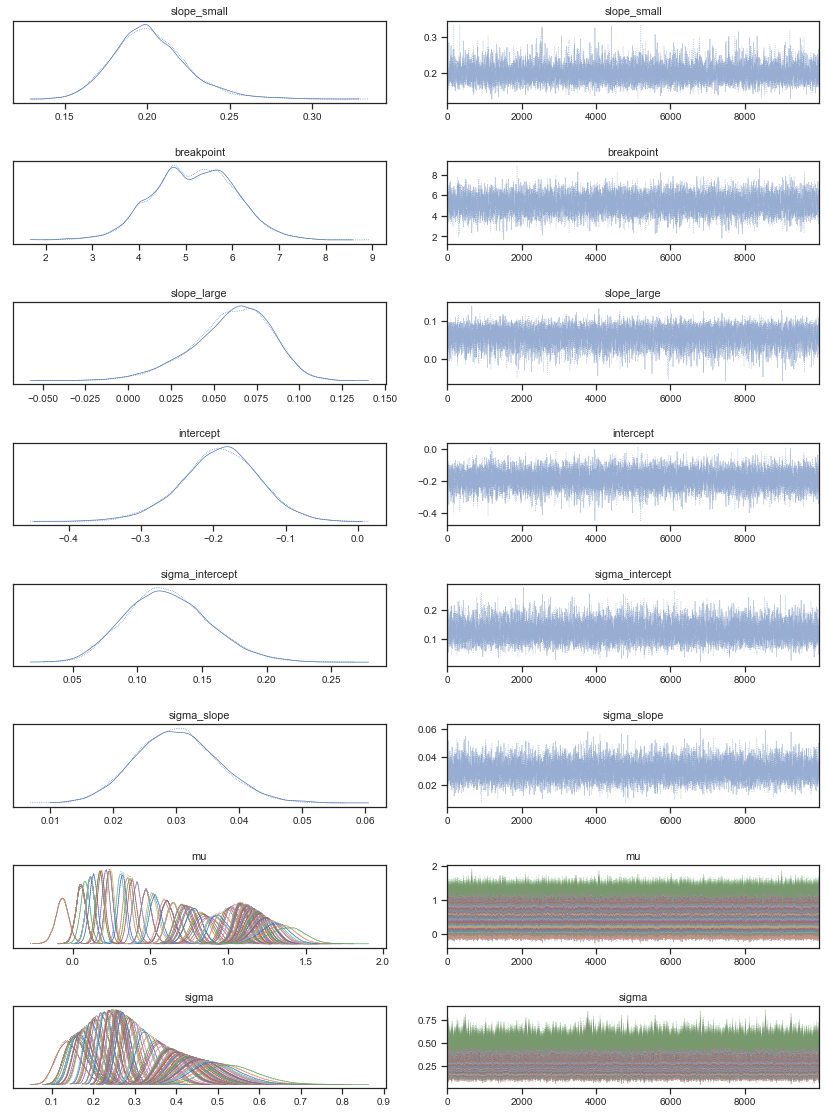

In [67]:
model = models[1]
print(model)

with pm.Model() as pm_model:

    # model definition
    intercept = pm.Uniform('intercept', lower=-0.5, upper=0.5, initval = 0.1)
    slope_small = pm.Normal('slope_small', mu=0, sigma=20)
    breakpoint = pm.Normal('breakpoint', mu=5, sigma=2, initval=5)
    slope_large = pm.Normal('slope_large', mu=0, sigma=20)

    part_1 = intercept + slope_small * x_dat
    part_2 = intercept + slope_small * breakpoint - slope_large * (breakpoint - x_dat)
    
    mu = pm.Deterministic('mu',pm.math.switch(breakpoint > x_dat,part_1,part_2))

    sigma_intercept = pm.HalfNormal('sigma_intercept',sigma=1,initval=0.3)
    sigma_slope = pm.HalfNormal('sigma_slope',sigma=1,initval=0.1)  
    sigma = pm.Deterministic('sigma',sigma_intercept + sigma_slope * x_dat) 
    
    likelihood = pm.Normal('y', mu=mu,sigma=sigma,observed=y_dat)
    
    # sampling
    trace[model] = pm.sample(Nsample,target_accept=0.8,tune=Ntune, progressbar=True,random_seed=rng)
    pm.sample_posterior_predictive(trace[model], extend_inferencedata=True,random_seed=rng)

# check trace
az.plot_trace(trace[model])
plt.tight_layout()

### Diminishing returns, constant sd

diminishing returns, constant sd


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, B, sigma]


Sampling 2 chains for 2_000 tune and 10_000 draw iterations (4_000 + 20_000 draws total) took 61 seconds.


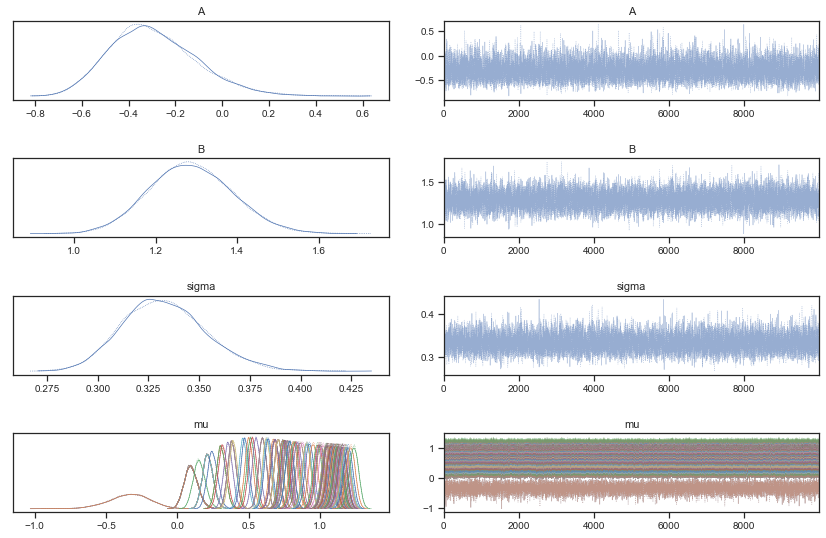

In [68]:
model = models[2]
print(model)

with pm.Model() as pm_model:
    
    #model definition
    A = pm.Normal('A', mu=0, sigma=20)
    B = pm.Normal('B', mu=0, sigma=20)
        
    mu = pm.Deterministic('mu',pm.math.log(A + B * x_dat)/pm.math.log(10))
    
    sigma = pm.HalfCauchy('sigma', beta=10, initval=1)

    likelihood = pm.Normal('y', mu=mu,sigma=sigma,observed=y_dat)

    #sampling
    trace[model] = pm.sample(Nsample,target_accept=0.99,tune=Ntune,progressbar=True,random_seed=rng)    
    pm.sample_posterior_predictive(trace[model], extend_inferencedata=True,random_seed=rng)
    
# check trace
az.plot_trace(trace[model])
plt.tight_layout()

### Diminishing returns, variable sd

diminishing returns, variable sd


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_intercept, sigma_slope, A, B]


Sampling 2 chains for 2_000 tune and 10_000 draw iterations (4_000 + 20_000 draws total) took 40 seconds.


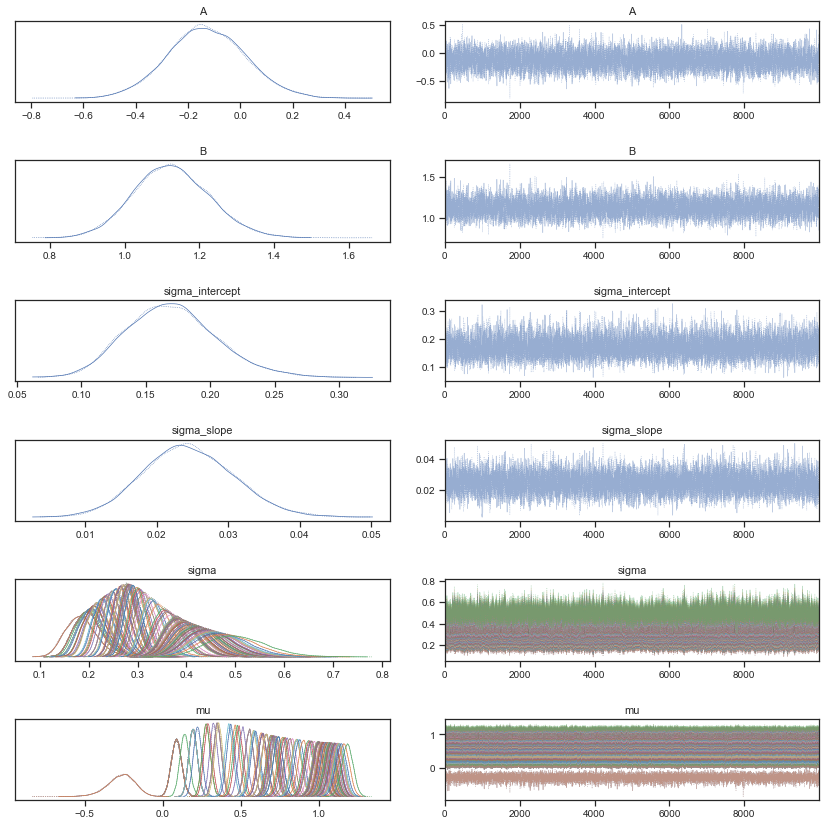

In [69]:
model = models[3]
print(model)

with pm.Model() as pm_model:
    
    #model definition
    sigma_intercept = pm.HalfNormal('sigma_intercept',sigma=1,initval=0.3)
    sigma_slope = pm.HalfNormal('sigma_slope',sigma=1,initval=0.1)    
    
    sigma = pm.Deterministic('sigma',sigma_intercept + sigma_slope * x_dat) 

    A = pm.Normal('A', mu=0, sigma=20)
    B = pm.Normal('B', mu=0, sigma=20)
        
    mu = pm.Deterministic('mu',pm.math.log(A + B * x_dat)/pm.math.log(10))

    likelihood = pm.Normal('y', mu=mu,sigma=sigma,observed=y_dat)

    # sampling
    trace[model] = pm.sample(Nsample,target_accept=0.8,tune=Ntune,progressbar=True,random_seed=rng)
    pm.sample_posterior_predictive(trace[model], extend_inferencedata=True,random_seed=rng)

#check trace
az.plot_trace(trace[model])
plt.tight_layout()

## Model comparison

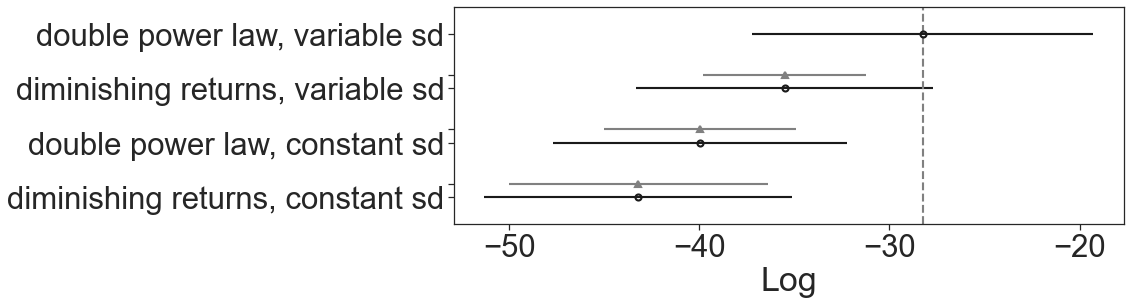

rank        loo     p_loo      d_loo  \
double power law, variable sd        0 -28.253092  5.557193   0.000000   
diminishing returns, variable sd     1 -35.515068  3.778740   7.261975   
double power law, constant sd        2 -39.961176  4.333464  11.708084   
diminishing returns, constant sd     3 -43.223526  2.600174  14.970434   

                                        weight        se       dse  warning  \
double power law, variable sd     8.645517e-01  8.966527  0.000000    False   
diminishing returns, variable sd  7.922377e-14  7.821408  4.271664    False   
double power law, constant sd     9.027036e-14  7.739625  5.068625    False   
diminishing returns, constant sd  1.354483e-01  8.081738  6.811246    False   

                                 loo_scale  
double power law, variable sd          log  
diminishing returns, variable sd       log  
double power law, constant sd          log  
diminishing returns, constant sd       log

In [70]:
model_compare = az.compare(trace,ic='loo')
az.plot_compare(model_compare,insample_dev=False, figsize=(12, 4))
plt.show()

model_compare

### Plot results (Figure 1)

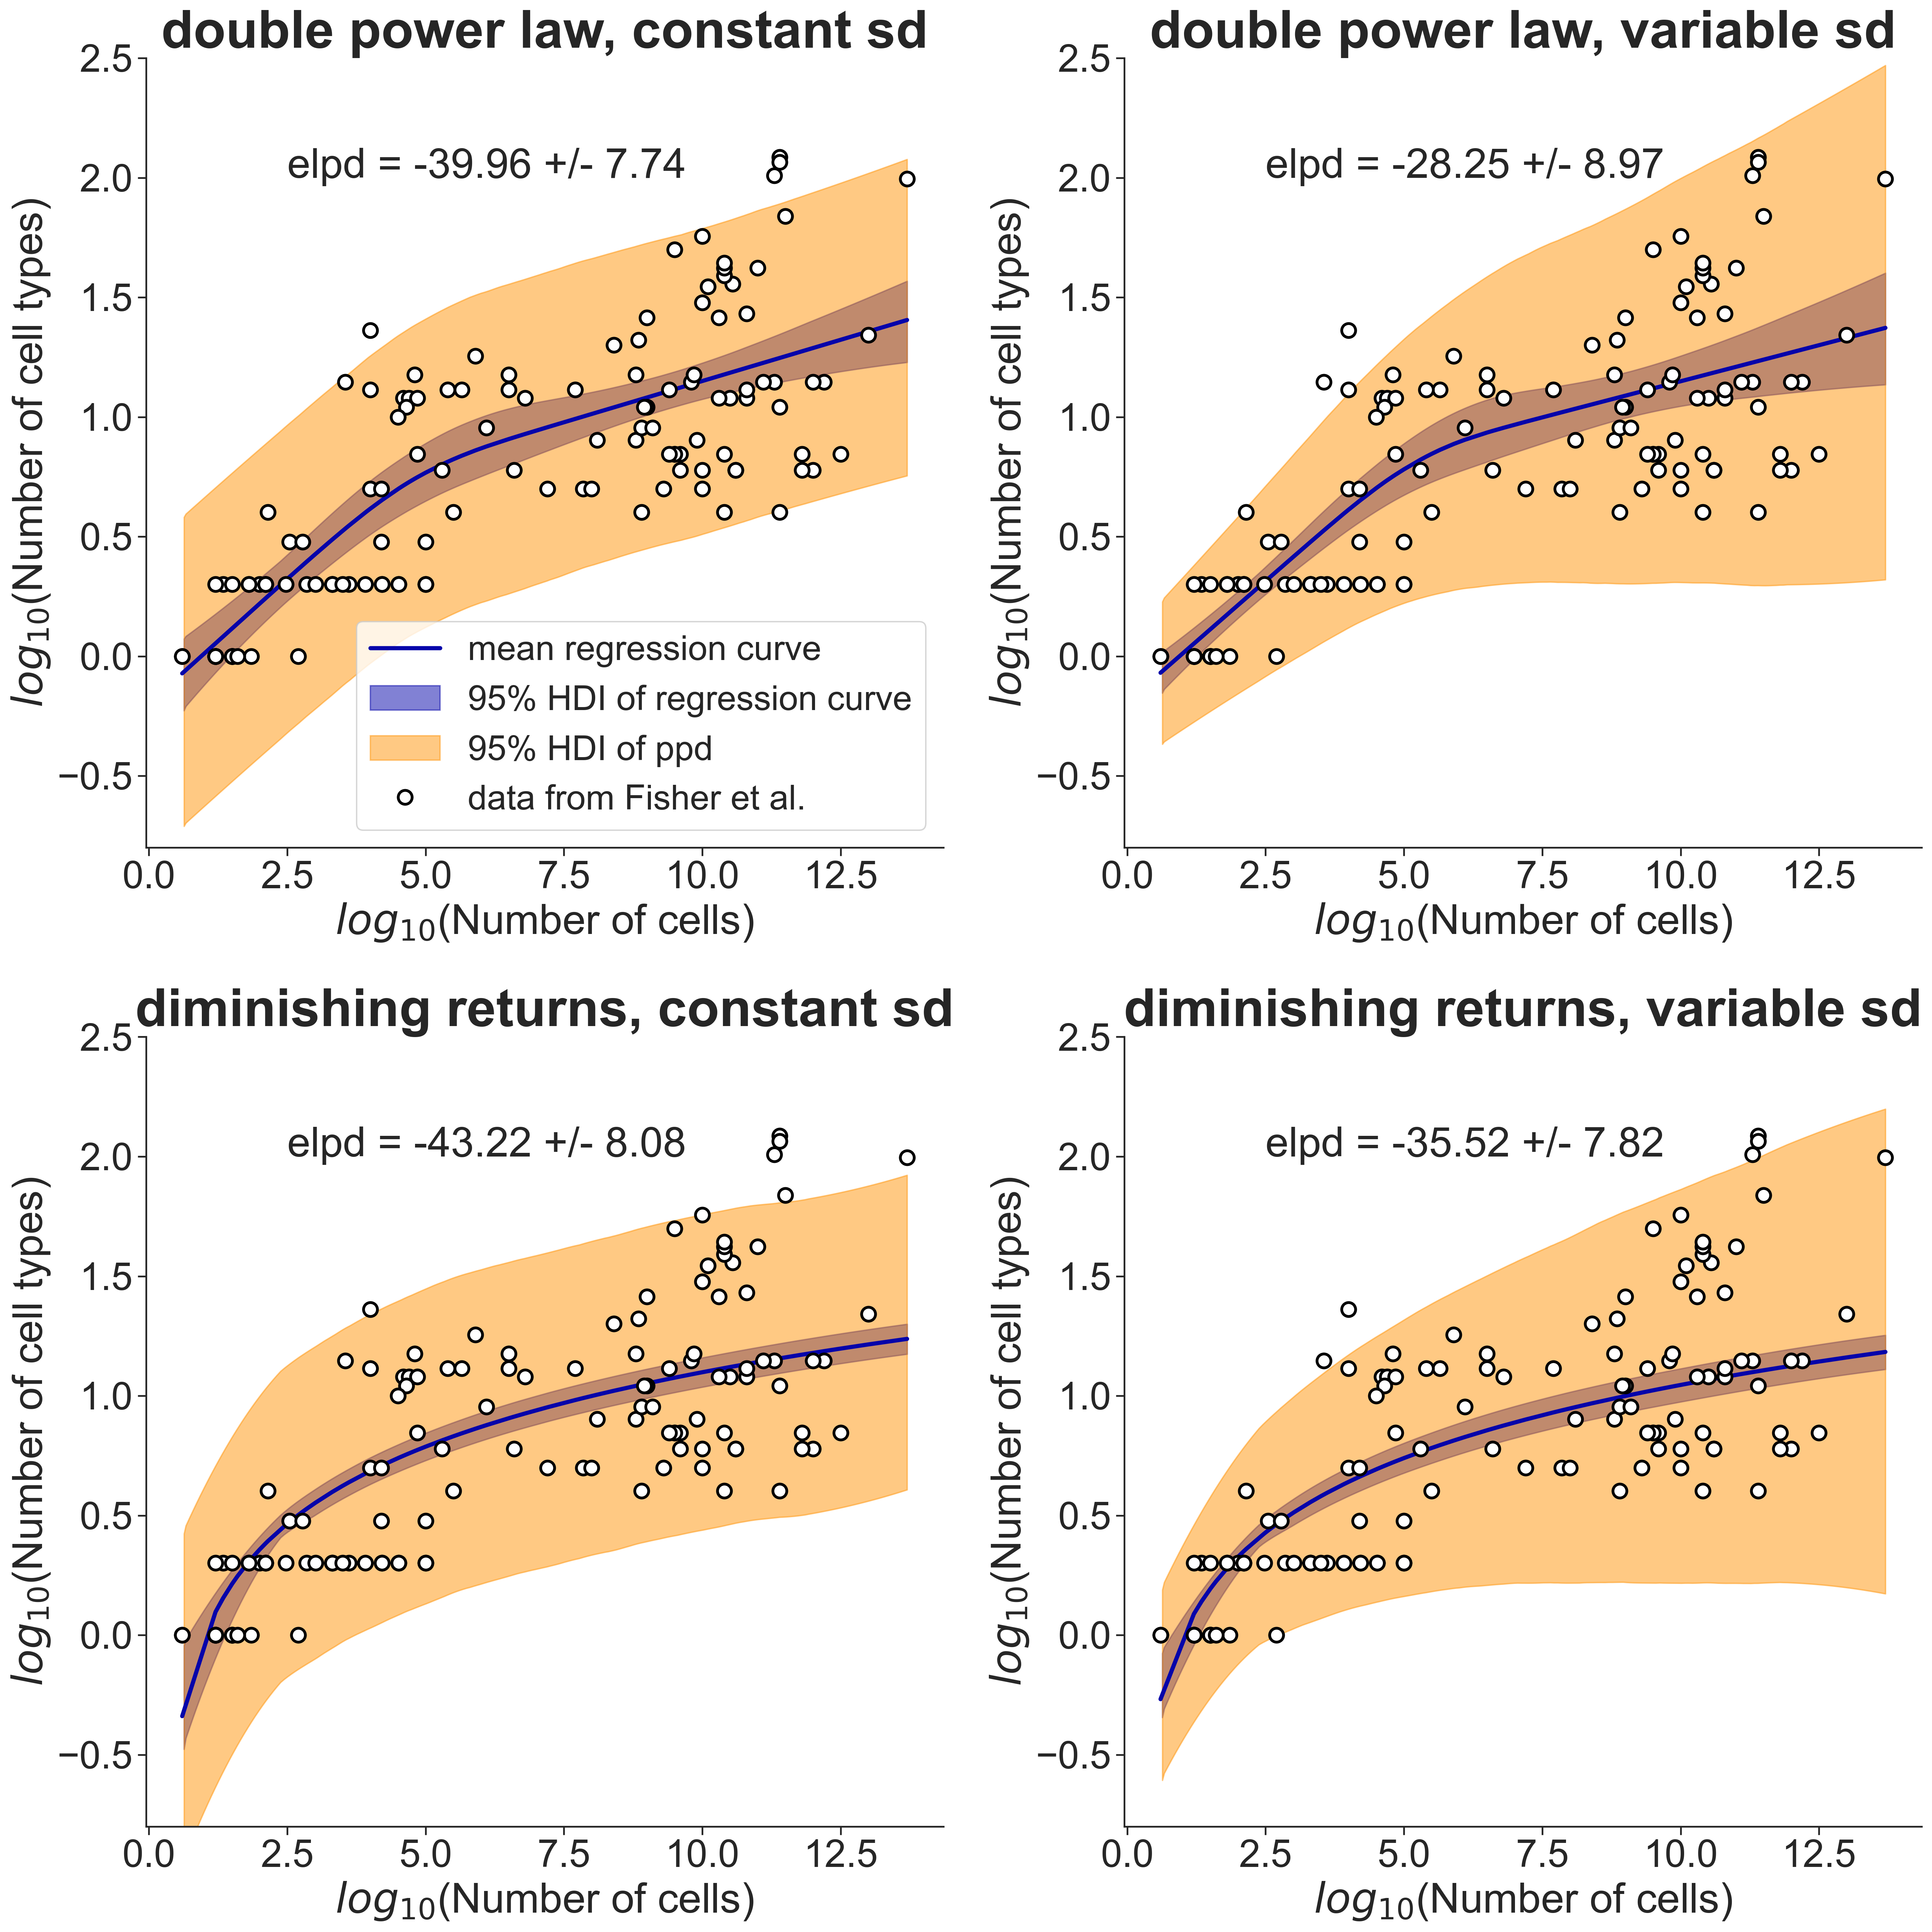

In [74]:
sns.set(font_scale=2.5,style="ticks")
fig,ax = plt.subplots(figsize=[20,20],ncols=2,nrows=2,dpi=300)

for count,model in enumerate(models):
    

    plot_model(dat,trace[model],np.ravel(ax)[count])
    np.ravel(ax)[count].set_title(model,fontsize=38,fontweight='bold')
    elpd = str(round(model_compare.loc[model,'loo'],2))
    elpd_se = str(round(model_compare.loc[model,'se'],2))
    np.ravel(ax)[count].text(2.5,2,'elpd = '+elpd+' +/- '+elpd_se,fontsize=30)
    
    if count ==0:
        np.ravel(ax)[count].legend(loc='lower right',fontsize=25)


sns.despine()
plt.tight_layout()
plt.savefig('figure1.jpeg',dpi=300)


### Save parameter estimates and result of model comparison (Table 1)

In [72]:

columns = ['Fisher et al.'] + models

params = ['intercept','slope_small','breakpoint','slope_large','A','B',
          'sigma','sigma_intercept','sigma_slope']

index = params + ['elpd']

results = pd.DataFrame(columns = columns, index=index)

for model in models:
          
    for param in params:
        if param in [i for i in trace[model].posterior.data_vars]:
            if not ((param == 'sigma') & ('variable' in model)): 
                results.loc[param,model] = (str(get_post_mean(trace[model],param)) + ' ' 
                                            + str(get_hdi(trace[model],param)))

        results.loc['elpd',model] = (str(round(model_compare.loc[model,'loo'],2)) + ' [' 
                                    + str(round(model_compare.loc[model,'se'],2)) + ']')


results.loc['slope_small','Fisher et al.'] = '0.21 [0.16 0.26]'
results.loc['slope_large','Fisher et al.'] = '0.07 [0.03 0.11]'
results.loc['breakpoint','Fisher et al.'] = '4.8 [3.9 5.7]'

results = results.loc[:,['Fisher et al.','double power law, constant sd','diminishing returns, constant sd',
                 'double power law, variable sd','diminishing returns, variable sd']]
results.to_csv('table1.csv')
results

Fisher et al. double power law, constant sd  \
intercept                     NaN            -0.2 [-0.41 -0.01]   
slope_small      0.21 [0.16 0.26]              0.21 [0.14 0.29]   
breakpoint          4.8 [3.9 5.7]              4.82 [2.81 6.64]   
slope_large      0.07 [0.03 0.11]              0.07 [0.03 0.1 ]   
A                             NaN                           NaN   
B                             NaN                           NaN   
sigma                         NaN              0.32 [0.29 0.37]   
sigma_intercept               NaN                           NaN   
sigma_slope                   NaN                           NaN   
elpd                          NaN                 -39.96 [7.74]   

                diminishing returns, constant sd  \
intercept                                    NaN   
slope_small                                  NaN   
breakpoint                                   NaN   
slope_large                                  NaN   
A                            -0.29 [-0.64  0.08]   
B                               1.29 [1.09 1.49]   
sigma                           0.33 [0.29 0.37]   
sigma_intercept                              NaN   
sigma_slope                                  NaN   
elpd                               -43.22 [8.08]   

                double power law, variable sd diminishing returns, variable sd  
intercept                 -0.19 [-0.3  -0.08]                              NaN  
slope_small                   0.2 [0.16 0.25]                              NaN  
breakpoint                   5.18 [3.52 6.84]                              NaN  
slope_large                  0.06 [0.01 0.1 ]                              NaN  
A                                         NaN              -0.13 [-0.42  0.16]  
B                                         NaN                 1.13 [0.94 1.33]  
sigma                                     NaN                              NaN  
sigma_intercept              0.12 [0.06 0.19]                 0.17 [0.1  0.24]  
sigma_slope                  0.03 [0.02 0.04]                 0.02 [0.01 0.04]  
elpd                            -28.25 [8.97]                    -35.52 [7.82]